In [1]:
'''
# ---- GPU setup (automatically inserted) ----
# This cell attempts to enable GPU acceleration for TensorFlow if a compatible GPU is present.
# It is safe (no changes to model logic) and only configures runtime behavior for better performance.
try:
    import tensorflow as tf
    # List GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print('GPUs found:', gpus)
    if gpus:
        try:
            # Allow memory growth (prevents TF from allocating all GPU memory up front)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print('Could not set memory growth:', e)
    # Enable mixed precision to speed up training on modern GPUs (keeps model numeric behavior compatible).
    try:
        from tensorflow.keras import mixed_precision
        # Only set policy if not already set
        current_policy = mixed_precision.global_policy().name
        if current_policy != 'mixed_float16':
            mixed_precision.set_global_policy('mixed_float16')
            print('Mixed precision set to mixed_float16')
        else:
            print('Mixed precision already set to', current_policy)
    except Exception as e:
        print('Mixed precision not set:', e)
    # If multiple GPUs are present, MirroredStrategy will automatically be used if the notebook opts in later.
    print('TensorFlow version:', tf.__version__)
except Exception as e:
    print('TensorFlow GPU setup cell failed:', e)
'''







"\n# ---- GPU setup (automatically inserted) ----\n# This cell attempts to enable GPU acceleration for TensorFlow if a compatible GPU is present.\n# It is safe (no changes to model logic) and only configures runtime behavior for better performance.\ntry:\n    import tensorflow as tf\n    # List GPUs\n    gpus = tf.config.list_physical_devices('GPU')\n    print('GPUs found:', gpus)\n    if gpus:\n        try:\n            # Allow memory growth (prevents TF from allocating all GPU memory up front)\n            for gpu in gpus:\n                tf.config.experimental.set_memory_growth(gpu, True)\n        except Exception as e:\n            print('Could not set memory growth:', e)\n    # Enable mixed precision to speed up training on modern GPUs (keeps model numeric behavior compatible).\n    try:\n        from tensorflow.keras import mixed_precision\n        # Only set policy if not already set\n        current_policy = mixed_precision.global_policy().name\n        if current_policy != 'm

In [2]:
'''!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/'''

'!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/'

In [3]:
#!kaggle datasets download -d mahyeks/almond-varieties

In [4]:
'''import zipfile
zip_ref = zipfile.ZipFile('/content/almond-varieties.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()'''

"import zipfile\nzip_ref = zipfile.ZipFile('/content/almond-varieties.zip', 'r')\nzip_ref.extractall('/content')\nzip_ref.close()"

In [5]:
#!pip install tensorflow

In [6]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [7]:
# Define image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)



# Define batch size
batch_size = 32

In [8]:
train_dir = 'train'
valid_dir = 'valid'


# Instantiate an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Create image generators for train and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    
)

Found 5327 images belonging to 4 classes.
Found 1334 images belonging to 4 classes.


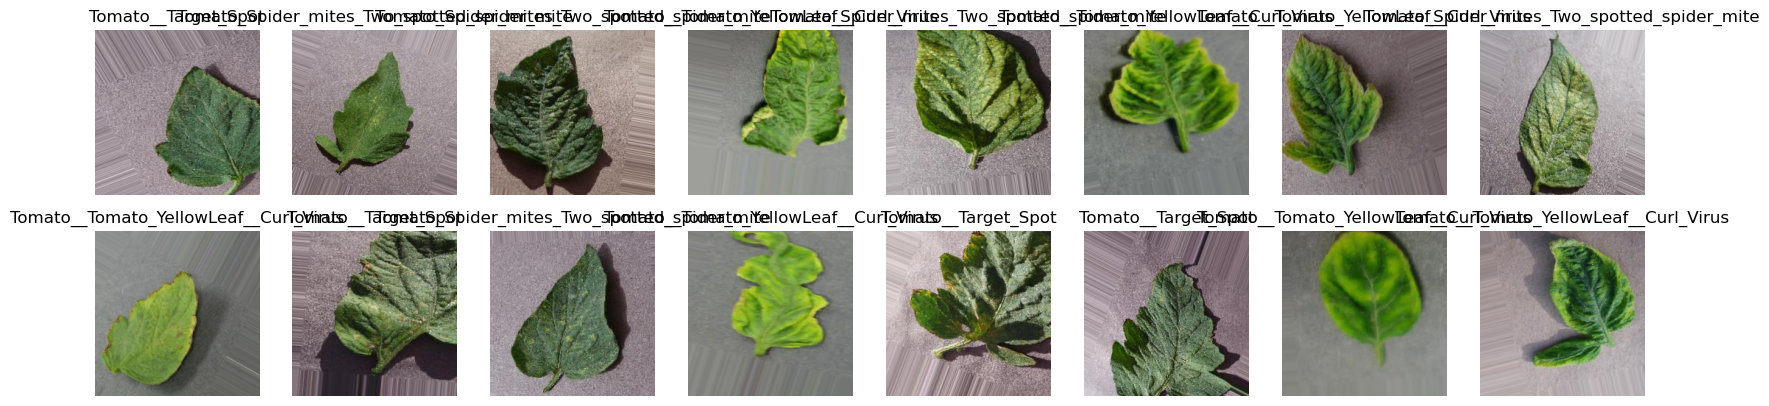

In [10]:
# Function to visualize images with proper classes
def visualize_images(generator, num_images):
    # Get a batch of images and labels
    images, labels = next(generator)
    labels = np.argmax(labels, axis=1)  # Convert one-hot encoding to class labels
    class_labels = list(generator.class_indices.keys())

    # Plot the images in a grid
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(4, 8, i+1)
        plt.imshow(images[i])
        plt.title(class_labels[labels[i]])
        plt.axis('off')
    plt.show()

# Visualize 16 random images from the training set
visualize_images(train_generator, 16)

In [11]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

In [12]:
# Load ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Add a Dropout layer for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
# Combine base model with custom top layers

model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Using a lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)

print("Training completed.")

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1492s 9s/step - accuracy: 0.4954 - loss: 2.1176 - val_accuracy: 0.6259 - val_loss: 1.1589 - learning_rate: 0.0010
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1459s 9s/step - accuracy: 0.5611 - loss: 1.1814 - val_accuracy: 0.5772 - val_loss: 1.0713 - learning_rate: 0.0010
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1439s 9s/step - accuracy: 0.5688 - loss: 1.1140 - val_accuracy: 0.6267 - val_loss: 1.0201 - learning_rate: 0.0010
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1487s 9s/step - accuracy: 0.5635 - loss: 1.1168 - val_accuracy: 0.6312 - val_loss: 1.0176 - learning_rate: 0.0010
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1437s 9s/step - accuracy: 0.5787 - loss: 1.0745 - val_accuracy: 0.6192 - val_loss: 0.9749 - learning_rate: 0.0010
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1457s 9s/step - accuracy: 0.5836 - loss: 1.0604 - val_accuracy: 0.6124 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1457s 9s/step - accuracy: 0.5814 - l

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [20]:
class_names = ['Tomato_Spider_mites_Two_spotted_spider_mite', 
               'Tomato__Target_Spot', 
               'Tomato__Tomato_mosaic_virus', 
               'Tomato__Tomato_YellowLeaf__Curl_Virus']
# Define data generators for Kaggle dataset paths
validation_data_dir = 'valid'

# Define data generator for the validation dataset
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: Set shuffle to False to match predictions with true labels
)

Found 1334 images belonging to 4 classes.


In [21]:
# Generate predictions on the validation data
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes

42/42 ━━━━━━━━━━━━━━━━━━━━ 274s 7s/step


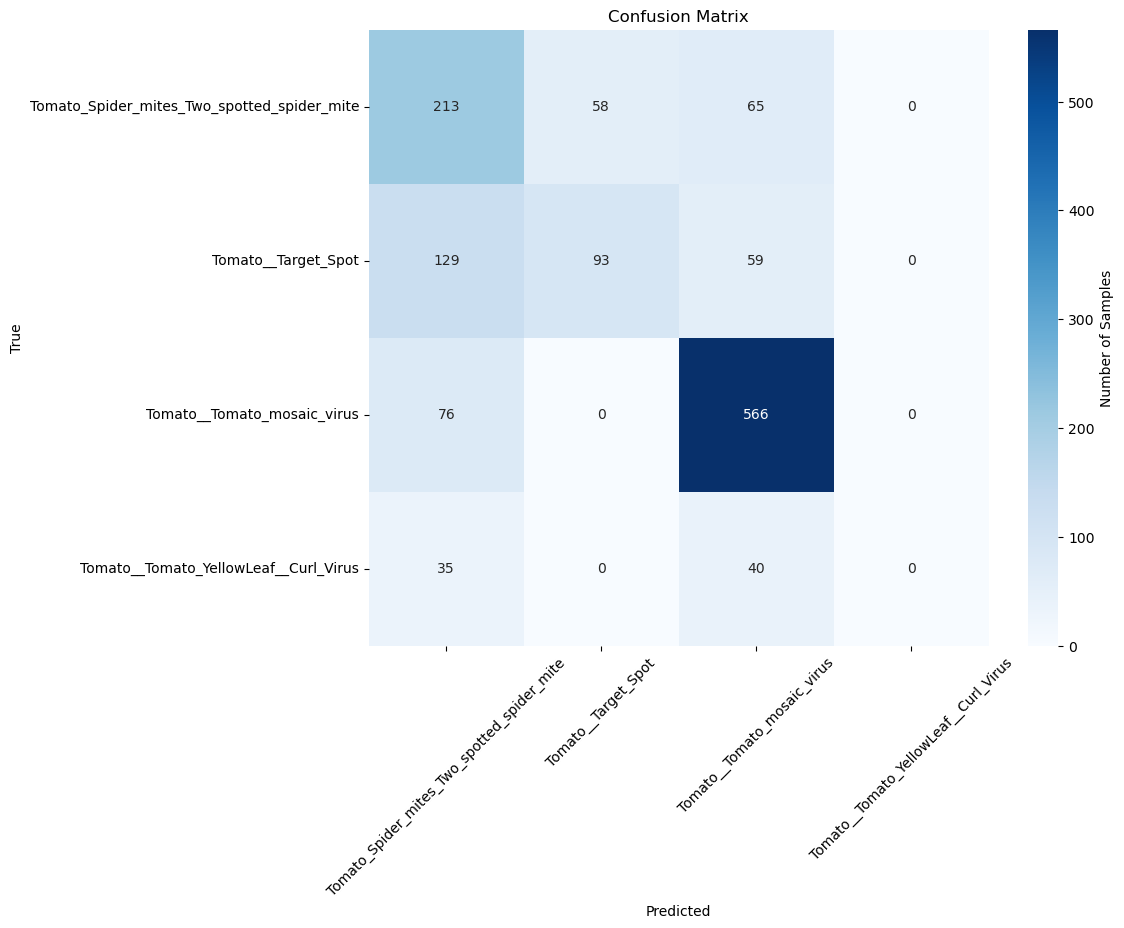

In [22]:
# Create the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix with rotated x-axis labels
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

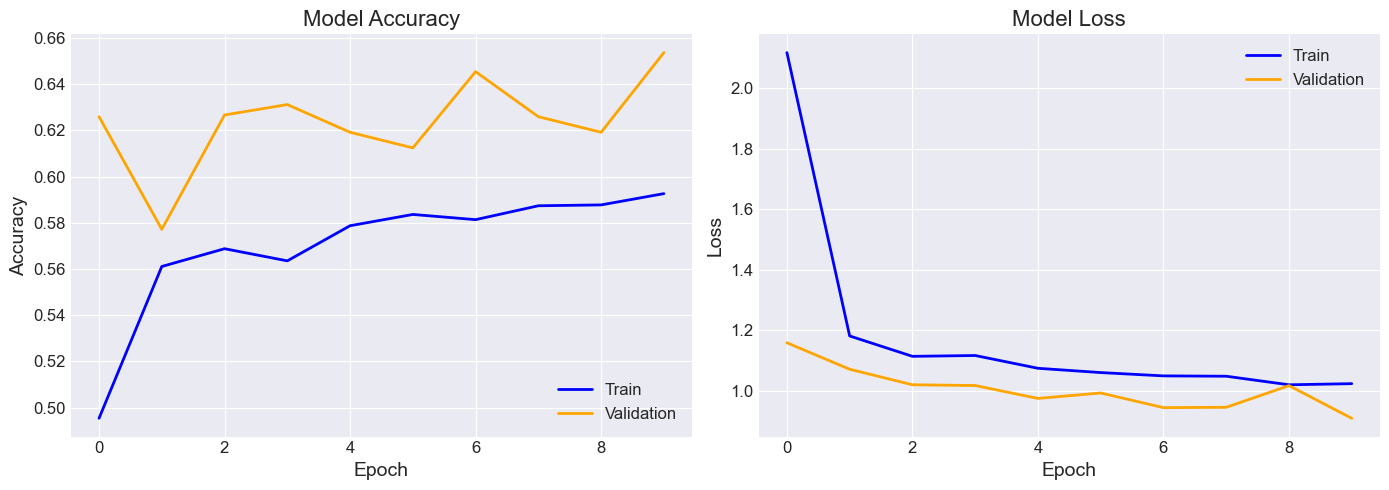

In [23]:
import matplotlib.pyplot as plt

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='blue', linestyle='-', linewidth=2, label='Train')
plt.plot(history.history['val_accuracy'], color='orange', linestyle='-', linewidth=2, label='Validation')
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Train')
plt.plot(history.history['val_loss'], color='orange', linestyle='-', linewidth=2, label='Validation')
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

In [24]:
# Print the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

                                             precision    recall  f1-score   support

Tomato_Spider_mites_Two_spotted_spider_mite       0.47      0.63      0.54       336
                        Tomato__Target_Spot       0.62      0.33      0.43       281
                Tomato__Tomato_mosaic_virus       0.78      0.88      0.83       642
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.00      0.00      0.00        75

                                   accuracy                           0.65      1334
                                  macro avg       0.47      0.46      0.45      1334
                               weighted avg       0.62      0.65      0.62      1334



C:\Users\rbsru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rbsru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rbsru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
